In [5]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from frouros.detectors.data_drift import KSTest

# Load and preprocess the data
data = pd.read_csv('EODHD_EURUSD_HISTORICAL_2019_2024_1min.csv').head(100000)
data = data[['close']]
data = np.log(data / data.shift(1))
data = data.dropna()
scaler = StandardScaler()
scaled_result = scaler.fit_transform(data.values.reshape(-1, 1))
data['close'] = pd.Series(scaled_result.flatten())

# Create the target variable using the next day's close price
data['target'] = data['close'].shift(-1).dropna()
data = data.dropna()

# Introduce artificial drift in the last 20% of the data
drift_size = int(len(data) * 0.2)
data['target'][-drift_size:] = data['target'][-drift_size:] + np.random.normal(0, 0.5, size=drift_size)

# Split the data into features and target
X = data[['close']].values
y = data['target'].values

# Split train (70%) and test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=31)

# Initialize and fit KS Test detector for the close feature
alpha = 0.01
detector = KSTest()
_ = detector.fit(X=X_train[:, 0])

# Train the model
model = DecisionTreeRegressor(random_state=31)
model.fit(X=X_train, y=y_train)

# Predict and evaluate the model
y_pred = model.predict(X=X_test)
print(f"Mean Squared Error: {round(mean_squared_error(y_test, y_pred), 4)}")

# Check for data drift in the original test set
p_value = detector.compare(X=X_test[:, 0])[0].p_value
print(f"p-value: {round(p_value, 4)}")
if p_value <= alpha:
    print("Data drift detected\n")
else:
    print("No data drift detected\n")

# Add noise to the close feature and evaluate the model
X_test_noise = X_test.copy()
X_test_noise[:, 0] = X_test_noise[:, 0] + np.random.normal(loc=0, scale=X_test_noise[:, 0].std(axis=0), size=X_test_noise[:, 0].shape)
y_pred = model.predict(X=X_test_noise)
print(f"Mean Squared Error with noise in close feature: {round(mean_squared_error(y_test, y_pred), 4)}")

# Check for data drift in the noisy test set
p_value = detector.compare(X=X_test_noise[:, 0])[0].p_value
print(f"p-value: {round(p_value, 4)}")
if p_value <= alpha:
    print("Data drift detected\n")
else:
    print("No data drift detected\n")

/var/folders/l0/091nq6390xb96z8313zhyp4m0000gp/T/ipykernel_20013/3263283566.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['target'][-drift_size:] = data['target'][-drift_size:] + np.random.normal(0, 0.5, size=drift_size)


Mean Squared Error: 1.9643
p-value: 0.0787
No data drift detected

Mean Squared Error with noise in close feature: 2.5894
p-value: 0.0
Data drift detected



100%|██████████| 1000/1000 [00:00<00:00, 1257.68it/s]


MMD statistic=0.2005, p-value=0.0009985
Drift detected. We can reject H0, so both samples come from different distributions.


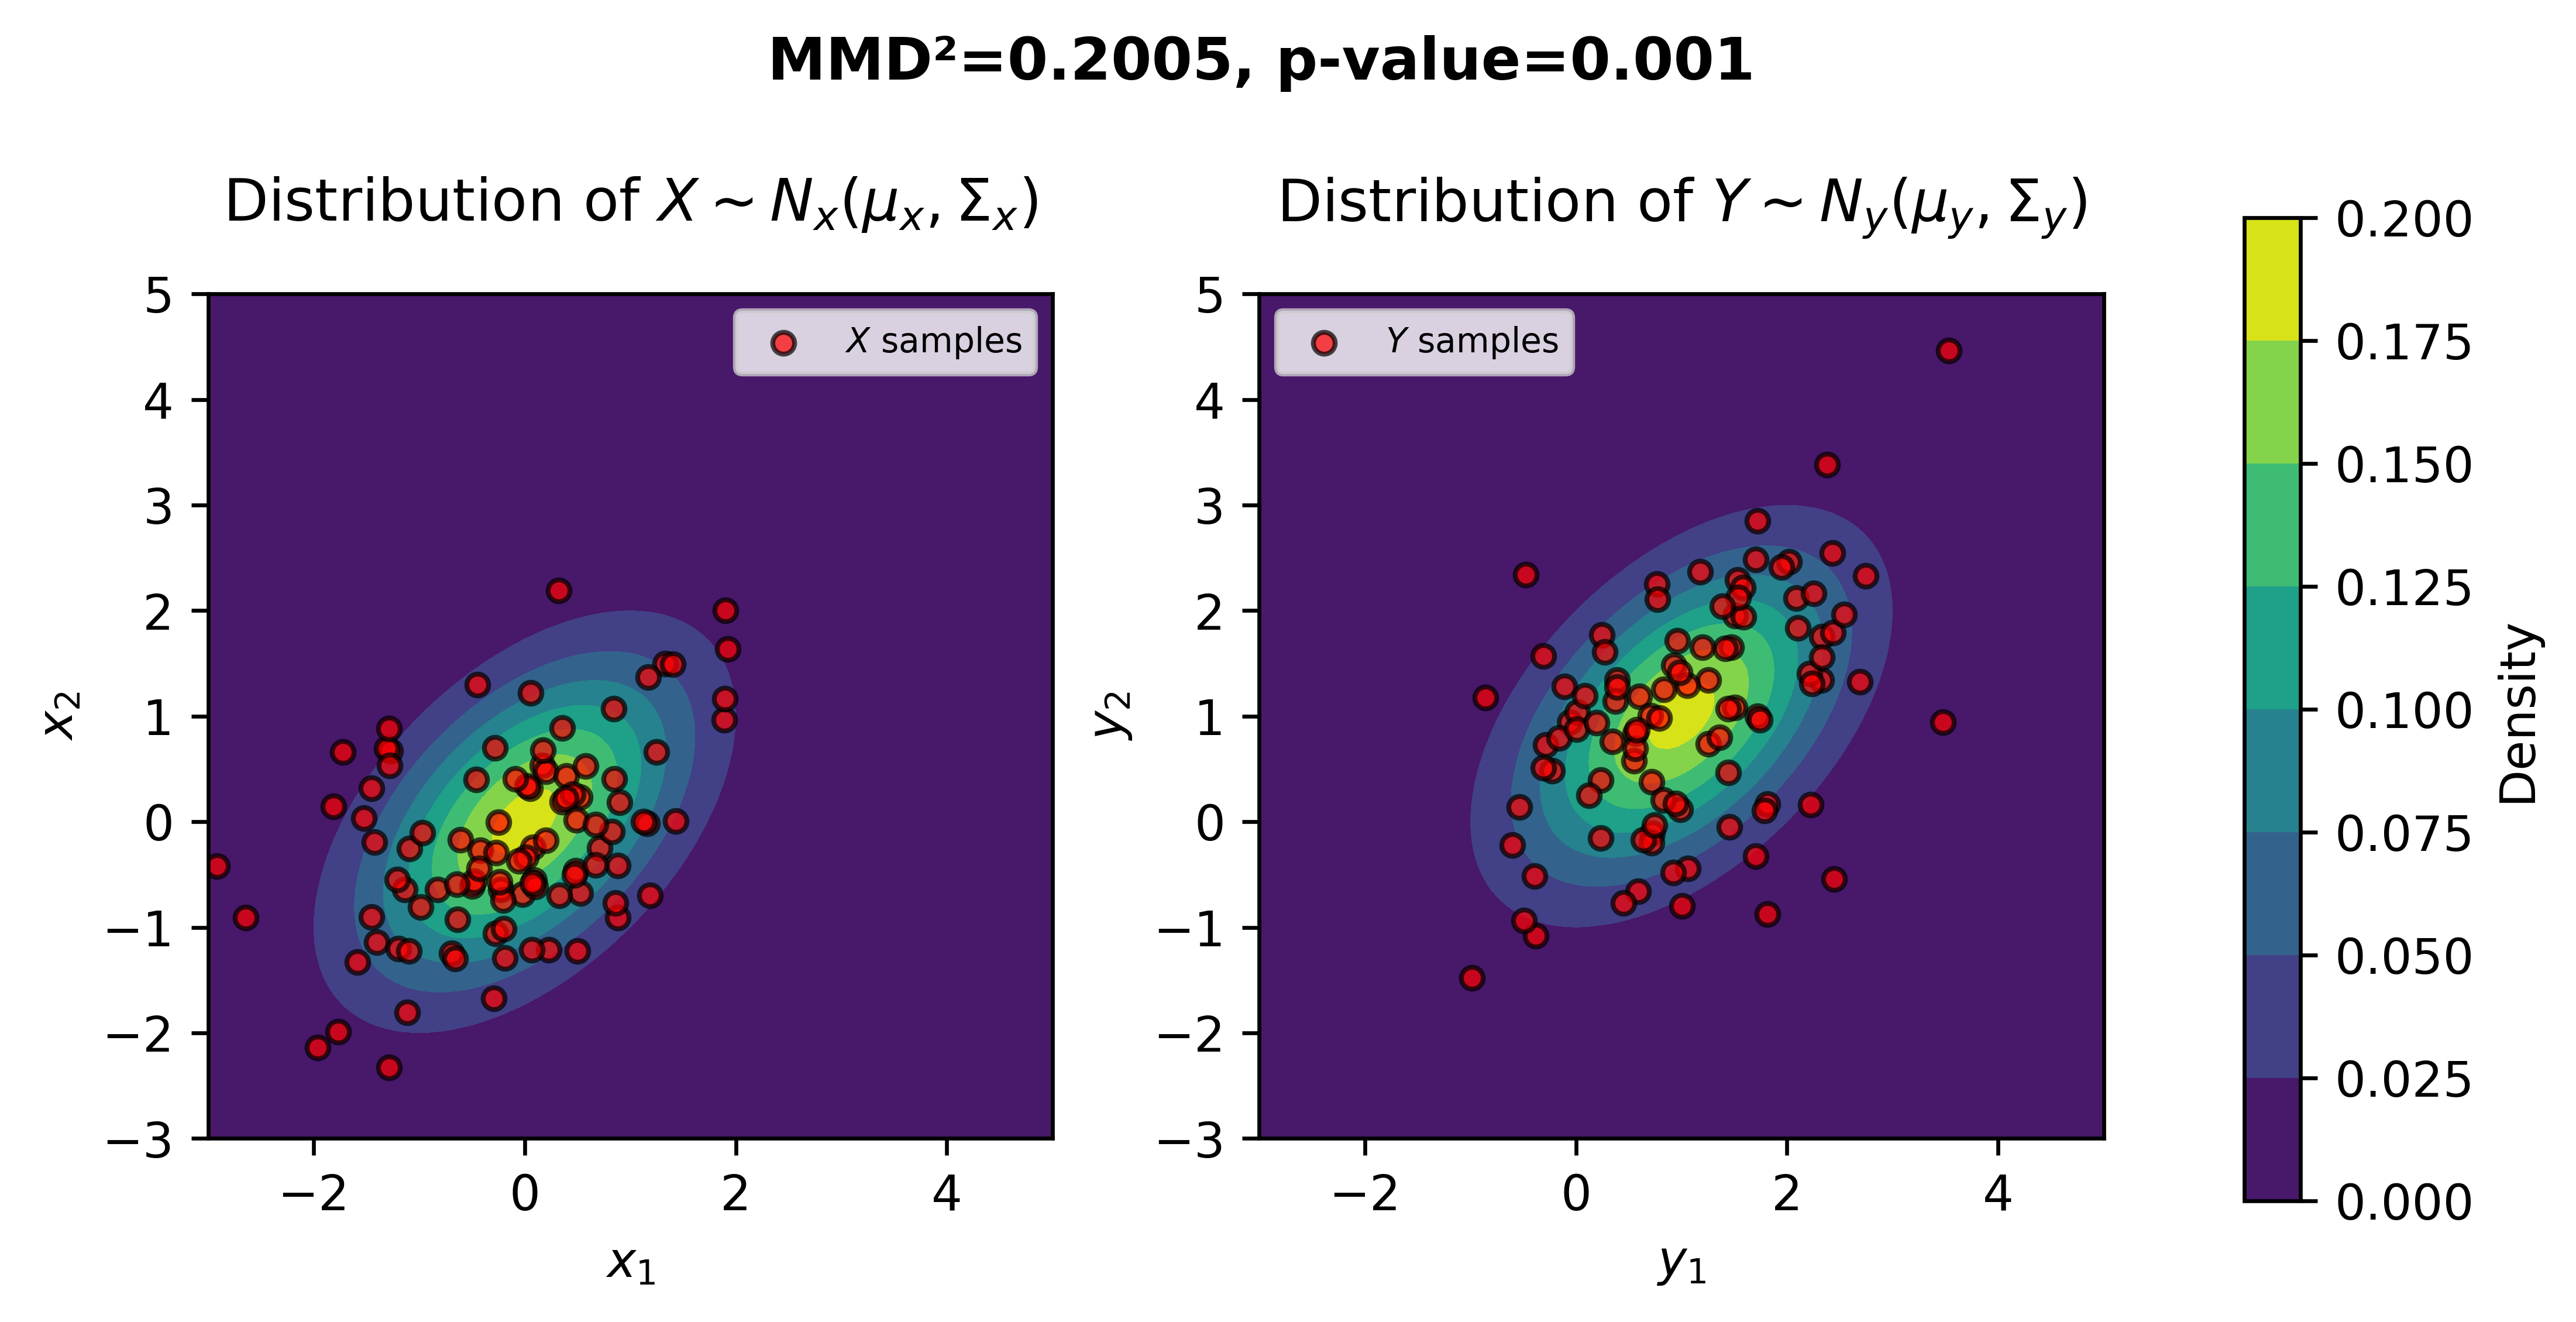

In [6]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist
from scipy.stats import multivariate_normal
from frouros.callbacks import PermutationTestDistanceBased
from frouros.detectors.data_drift import MMD
from frouros.utils.kernels import rbf_kernel

# Parameters
num_samples = 100
x_mean = [0, 0]
x_cov = [[1, 0.5], [0.5, 1]]
y_mean = [1, 1]
y_cov = [[1, 0.5], [0.5, 1]]
seed = 31

# Generate reference and test samples
X_ref = np.random.multivariate_normal(mean=x_mean, cov=x_cov, size=num_samples)
X_test = np.random.multivariate_normal(mean=y_mean, cov=y_cov, size=num_samples)

# MMD detector configuration
alpha = 0.01
sigma = np.median(pdist(X=np.vstack((X_ref, X_test)), metric="euclidean")) / 2

detector = MMD(
    kernel=partial(rbf_kernel, sigma=sigma),
    callbacks=[
        PermutationTestDistanceBased(
            num_permutations=1000,
            random_state=seed,
            num_jobs=-1,
            method="exact",
            name="permutation_test",
            verbose=True,
        ),
    ],
)

# Fit the detector on the reference data
detector.fit(X=X_ref)

# Compare the test data with the reference data
mmd, callbacks_log = detector.compare(X=X_test)
p_value = callbacks_log["permutation_test"]["p_value"]

# Print the results
print(f"MMD statistic={round(mmd.distance, 4)}, p-value={round(p_value, 8)}")
if p_value <= alpha:
    print("Drift detected. We can reject H0, so both samples come from different distributions.")
else:
    print("No drift detected. We fail to reject H0, so both samples come from the same distribution.")

# Visualization
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), dpi=600)

x1_ref_min, x2_ref_min = X_ref.min(axis=0)
x1_test_min, x2_test_min = X_test.min(axis=0)
x1_ref_max, x2_ref_max = X_ref.max(axis=0)
x1_test_max, x2_test_max = X_test.max(axis=0)

x_min = np.floor(np.min([x1_ref_min, x1_test_min, x2_ref_min, x2_test_min]))
x_max = np.ceil(np.max([x1_ref_max, x1_test_max, x2_ref_max, x2_test_max]))
x_max = x_max if x_min != x_max else x_max + 1

x1_val = np.linspace(x_min, x_max, num=num_samples)
x2_val = np.linspace(x_min, x_max, num=num_samples)
x1, x2 = np.meshgrid(x1_val, x2_val)

px_grid = np.zeros((num_samples, num_samples))
qy_grid = np.zeros((num_samples, num_samples))

for i in range(num_samples):
    for j in range(num_samples):
        px_grid[i, j] = multivariate_normal.pdf([x1_val[i], x2_val[j]], x_mean, x_cov)
        qy_grid[i, j] = multivariate_normal.pdf([x1_val[i], x2_val[j]], y_mean, y_cov)

marker = "o"
facecolor = "r"
edgecolor = "k"
alpha = 0.7
marker_size = 20

CS1 = ax1.contourf(x1, x2, px_grid)
ax1.set_title("Distribution of $X \sim N_{x}(\mu_{x}, \Sigma_{x})$", pad=15)
ax1.set_ylabel('$x_2$')
ax1.set_xlabel('$x_1$')
ax1.set_aspect('equal')
ax1.scatter(X_ref[:, 0], X_ref[:, 1],
            label="$X$ samples",
            marker=marker,
            facecolor=facecolor,
            edgecolor=edgecolor,
            alpha=alpha,
            s=marker_size)
ax1.legend(fontsize=7)

CS2 = ax2.contourf(x1, x2, qy_grid)
ax2.set_title("Distribution of $Y \sim N_{y}(\mu_{y}, \Sigma_{y})$", pad=15)
ax2.set_xlabel('$y_1$')
ax2.set_ylabel('$y_2$')
ax2.set_aspect('equal')
ax2.scatter(X_test[:, 0], X_test[:, 1],
            label="$Y$ samples",
            marker=marker,
            facecolor=facecolor,
            edgecolor=edgecolor,
            alpha=alpha,
            s=marker_size)
ax2.legend(fontsize=7)

fig.subplots_adjust(right=0.8, wspace=0.245)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(CS2, cax=cbar_ax)
cbar.ax.set_ylabel('Density')
plt.suptitle(f"MMD²={round(mmd.distance, 4)}, p-value={round(p_value, 4)}", y=0.98, fontweight="bold")
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from functools import partial
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from frouros.callbacks import PermutationTestDistanceBased
from frouros.detectors.data_drift import MMD
from frouros.utils.kernels import rbf_kernel

# Load and preprocess the data
data = pd.read_csv('EODHD_EURUSD_HISTORICAL_2019_2024_1min.csv').head(100000)
data = data[['close']]
data = np.log(data / data.shift(1))
data = data.dropna()
scaler = StandardScaler()
scaled_result = scaler.fit_transform(data.values.reshape(-1, 1))
data['close'] = pd.Series(scaled_result.flatten())

# Create the target variable using the next day's close price
data['target'] = data['close'].shift(-1).dropna()
data = data.dropna()

# Introduce artificial drift in the last 20% of the data
drift_size = int(len(data) * 0.2)
data['target'][-drift_size:] = data['target'][-drift_size:] + np.random.normal(0, 0.5, size=drift_size)

# Split the data into features and target
X = data[['close']].values
y = data['target'].values

# Split train (70%) and test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=31)

# MMD detector configuration
alpha = 0.01
sigma = np.median(pdist(X=np.vstack((X_train, X_test)), metric="euclidean")) / 2

detector = MMD(
    kernel=partial(rbf_kernel, sigma=sigma),
    callbacks=[
        PermutationTestDistanceBased(
            num_permutations=1000,
            random_state=31,
            num_jobs=-1,
            method="exact",
            name="permutation_test",
            verbose=True,
        ),
    ],
)

# Fit the detector on the training data
detector.fit(X=X_train)

# Compare the test data with the training data
mmd, callbacks_log = detector.compare(X=X_test)
p_value = callbacks_log["permutation_test"]["p_value"]

# Print the results
print(f"MMD statistic={round(mmd.distance, 4)}, p-value={round(p_value, 8)}")
if p_value <= alpha:
    print("Drift detected. We can reject H0, so both samples come from different distributions.")
else:
    print("No drift detected. We fail to reject H0, so both samples come from the same distribution.")

# Visualization
fig, ax = plt.subplots(figsize=(8, 4), dpi=600)

# Plot the training and test data
ax.plot(X_train, label='Training Data', color='blue')
ax.plot(range(len(X_train), len(X_train) + len(X_test)), X_test, label='Test Data', color='red')

ax.set_title(f"MMD²={round(mmd.distance, 4)}, p-value={round(p_value, 4)}", fontweight="bold")
ax.set_xlabel('Time')
ax.set_ylabel('Scaled Close Price')
ax.legend()

plt.show()

## Final

/var/folders/l0/091nq6390xb96z8313zhyp4m0000gp/T/ipykernel_1142/1881095107.py:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['target'][-drift_size:] = data['target'][-drift_size:] + np.random.normal(0, 0.5, size=drift_size)
100%|████

MMD statistic=-0.0014, p-value=0.72327622
No drift detected. We fail to reject H0, so both samples come from the same distribution.


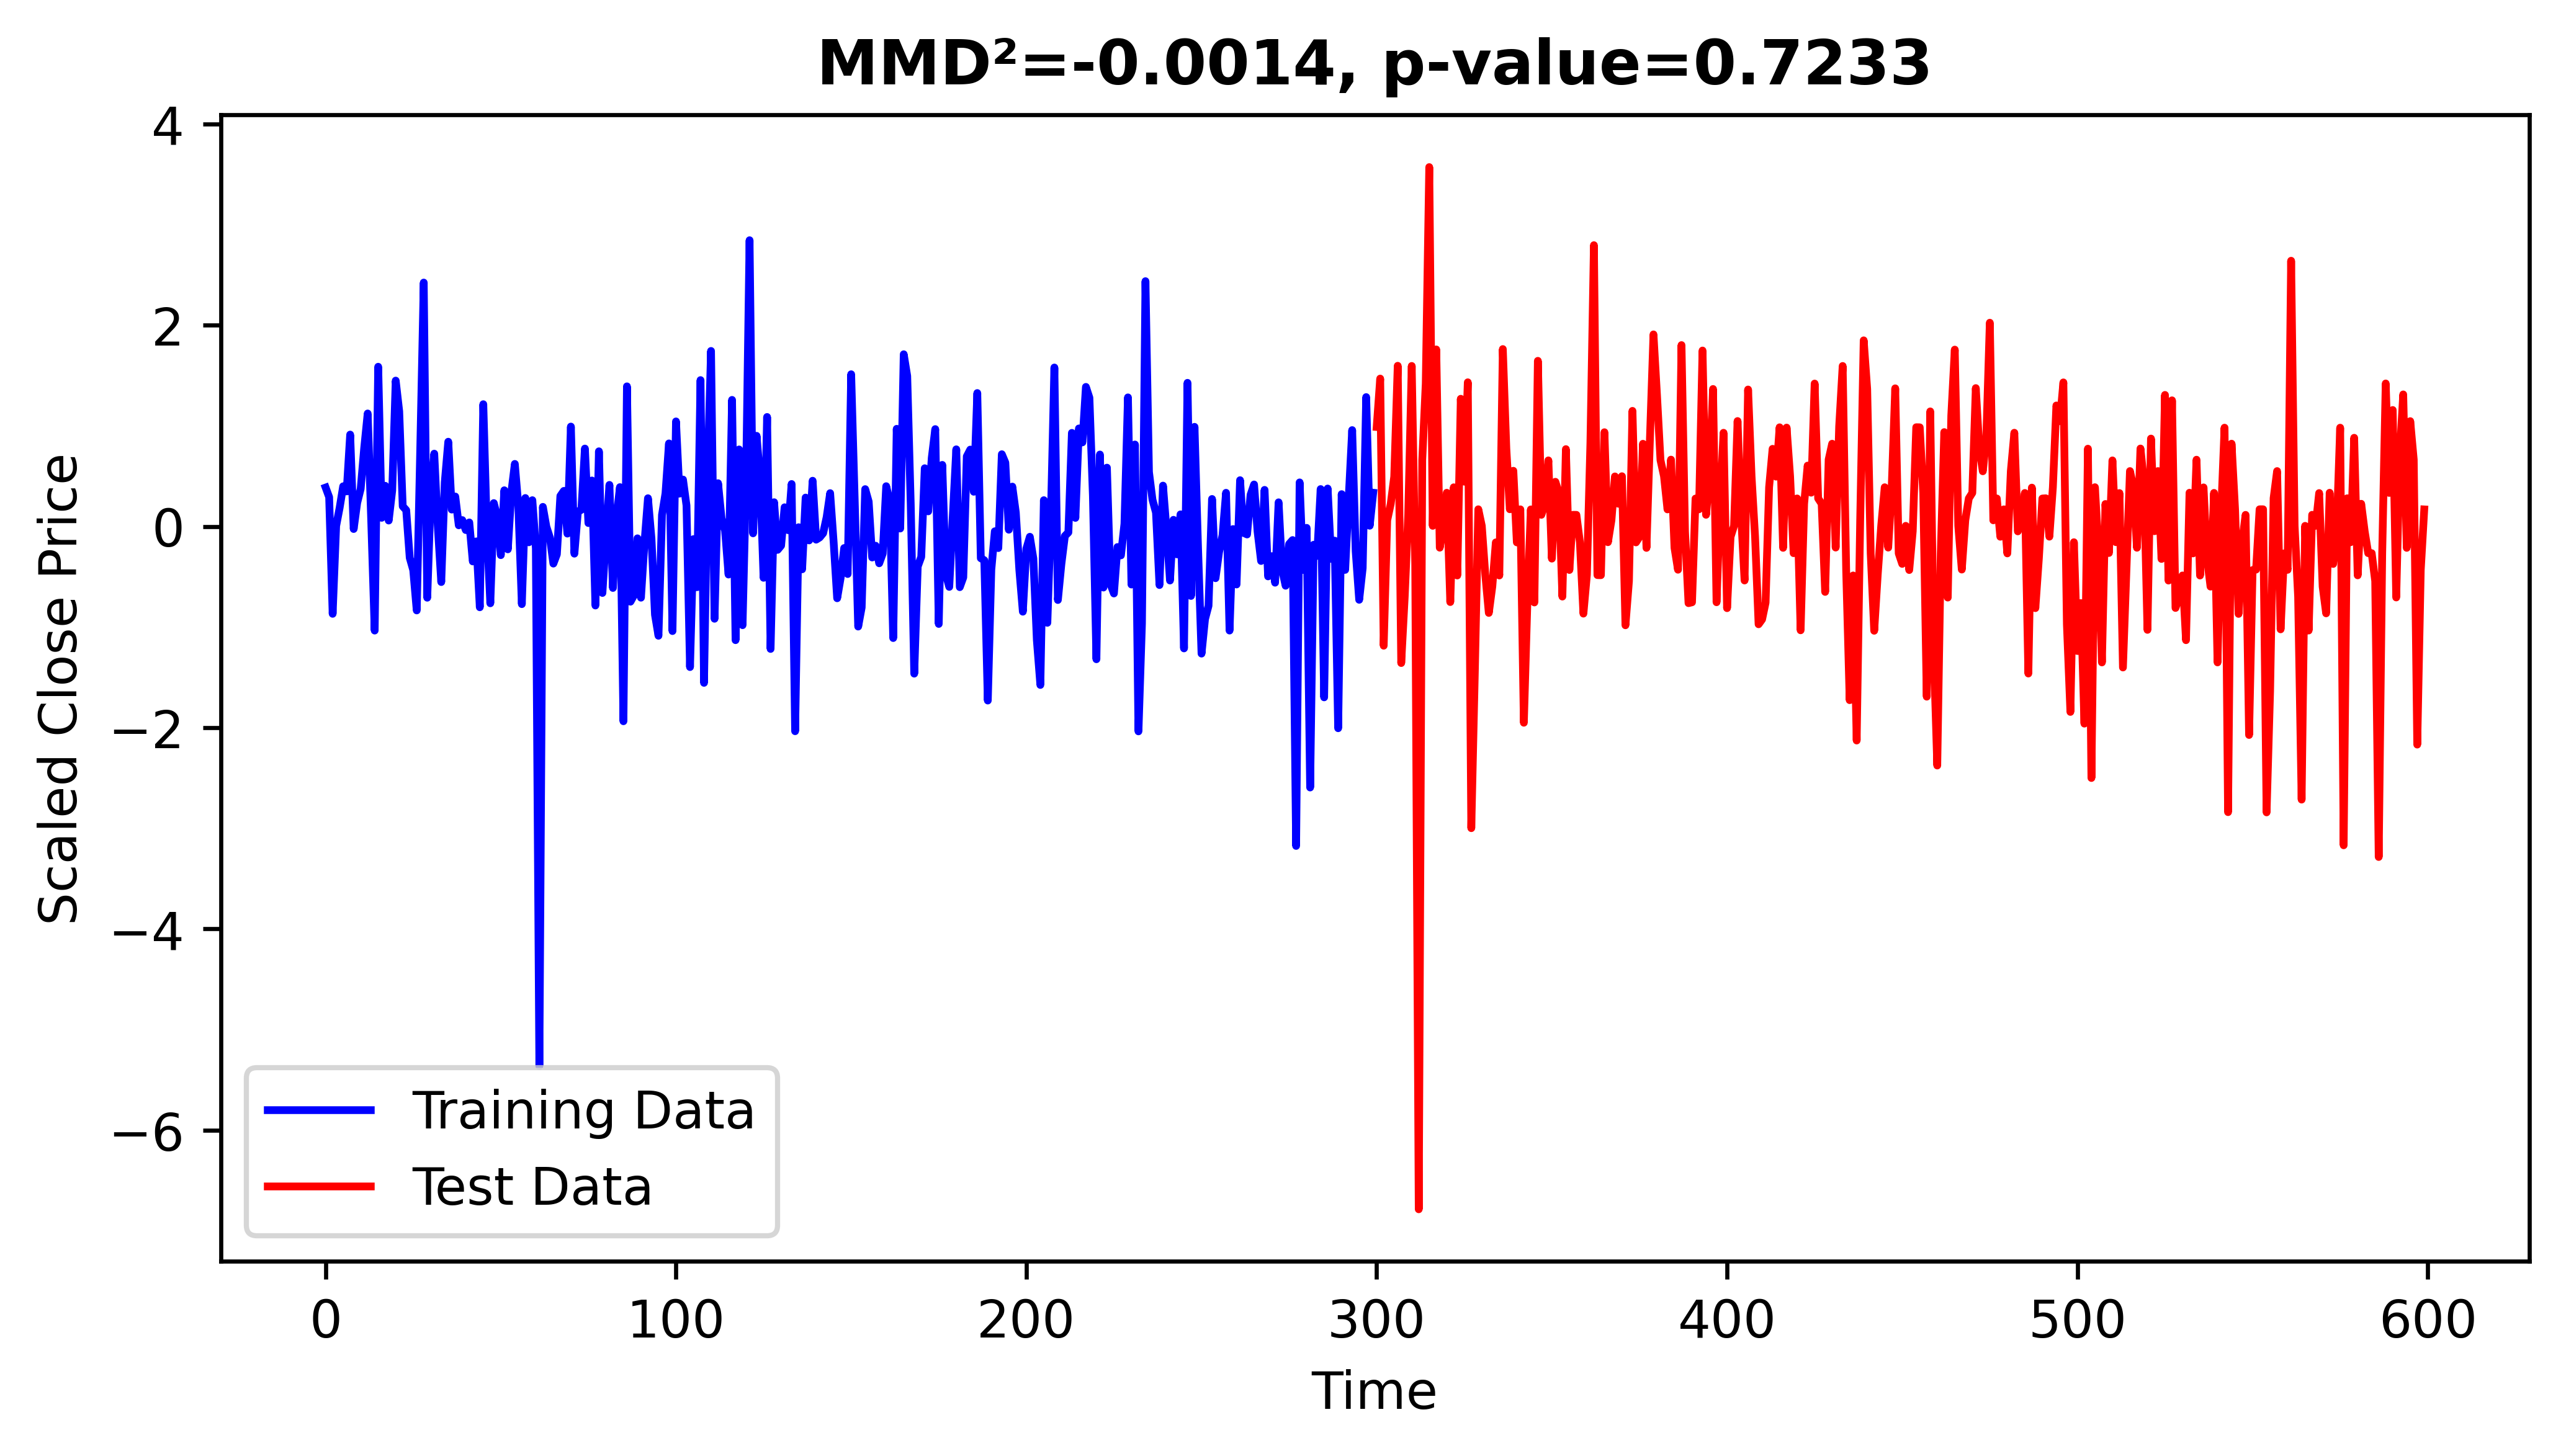

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from functools import partial
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from frouros.callbacks import PermutationTestDistanceBased
from frouros.detectors.data_drift import MMD
from frouros.utils.kernels import rbf_kernel

# Load and preprocess the data
data = pd.read_csv('EODHD_EURUSD_HISTORICAL_2019_2024_1min.csv').head(1000)
data = data[['close']]
data = np.log(data / data.shift(1))
data = data.dropna()
scaler = StandardScaler()
scaled_result = scaler.fit_transform(data.values.reshape(-1, 1))
data['close'] = pd.Series(scaled_result.flatten())

# Create the target variable using the next day's close price
data['target'] = data['close'].shift(-1).dropna()
data = data.dropna()

# Introduce artificial drift in the last 20% of the data
drift_size = int(len(data) * 0.2)
data['target'][-drift_size:] = data['target'][-drift_size:] + np.random.normal(0, 0.5, size=drift_size)

# Split the data into features and target
X = data[['close']].values
y = data['target'].values

# Split train (70%) and test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=31)

# Interpolate to bring both datasets to the same length
length = min(len(X_train), len(X_test))
X_train_interp = np.interp(np.linspace(0, len(X_train) - 1, length), np.arange(len(X_train)), X_train.flatten())
X_test_interp = np.interp(np.linspace(0, len(X_test) - 1, length), np.arange(len(X_test)), X_test.flatten())

# MMD detector configuration
alpha = 0.01
sigma = np.median(pdist(X=np.vstack((X_train, X_test)), metric="euclidean")) / 2

detector = MMD(
    kernel=partial(rbf_kernel, sigma=sigma),
    callbacks=[
        PermutationTestDistanceBased(
            num_permutations=1000,
            random_state=31,
            num_jobs=-1,
            method="exact",
            name="permutation_test",
            verbose=True,
        ),
    ],
)

# Fit the detector on the training data
detector.fit(X=X_train)

# Compare the test data with the training data
mmd, callbacks_log = detector.compare(X=X_test)
p_value = callbacks_log["permutation_test"]["p_value"]

# Print the results
print(f"MMD statistic={round(mmd.distance, 4)}, p-value={round(p_value, 8)}")
if p_value <= alpha:
    print("Drift detected. We can reject H0, so both samples come from different distributions.")
else:
    print("No drift detected. We fail to reject H0, so both samples come from the same distribution.")

# Visualization
fig, ax = plt.subplots(figsize=(8, 4), dpi=600)

# Plot the training and test data
ax.plot(X_train_interp, label='Training Data', color='blue')
ax.plot(range(len(X_train_interp), len(X_train_interp) + len(X_test_interp)), X_test_interp, label='Test Data', color='red')

ax.set_title(f"MMD²={round(mmd.distance, 4)}, p-value={round(p_value, 4)}", fontweight="bold")
ax.set_xlabel('Time')
ax.set_ylabel('Scaled Close Price')
ax.legend()

plt.show()